## Imports {-}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import re
import contractions
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words

In [2]:
merged_df = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/mimic_admissions_and_discharge/1 Data Preprocessing/mimic_text_labels_merged_cleaned_no_zeros.csv')
merged_df

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID,ADMISSION_TYPE
0,153714.0,1.0,5849,Discharge summary,Admission Date: [**2159-7-6**] Discharg...,51,29492,24136,EMERGENCY
1,165367.0,1.0,51881,Nursing/other,FOCUS; NURISNG PROGRESS NOTE\n(Continued)\nSPL...,65,36317,29799,EMERGENCY
2,129565.0,1.0,51881,Discharge summary,Admission Date: [**2146-6-1**] D...,79,47150,62854,EMERGENCY
3,141170.0,1.0,51881,Nursing,"Hypoglycemia\n Assessment:\n Pt. BS 114, 1...",65,36132,29631,EMERGENCY
4,184643.0,1.0,5849,Discharge summary,Admission Date: [**2136-1-21**] ...,59,17278,14106,EMERGENCY
...,...,...,...,...,...,...,...,...,...
31972,154989.0,32.0,53081,Nursing/other,Respiratory Care:\n\nPatient intubated for inc...,65,30465,24955,EMERGENCY
31973,133827.0,32.0,53081,Radiology,[**2194-4-24**] 2:07 PM\n CHEST PORT. LINE PLA...,73,48045,65659,ELECTIVE
31974,179548.0,32.0,4019,Discharge summary,Admission Date: [**2182-8-1**] [...,79,48580,67348,EMERGENCY
31975,129551.0,36.0,4019,Radiology,[**2160-5-11**] 1:51 PM\n LUMBAR PUNCTURE ...,51,51769,77282,EMERGENCY


## Filter AGE > 120 {-}

In [3]:
merged_df[merged_df['AGE']>120]

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID,ADMISSION_TYPE


In [4]:
# merged_df.drop(merged_df[merged_df.AGE > 120].index, inplace=True)
# merged_df

## Filtering AGE = 0 {-}

In [5]:
(merged_df['AGE']==0).sum()

0

In [6]:
# merged_df.drop(merged_df[merged_df.AGE == 0].index, inplace=True)
# merged_df.info()

## Age Distribution on Current Data {-}

<AxesSubplot:xlabel='AGE', ylabel='Count'>

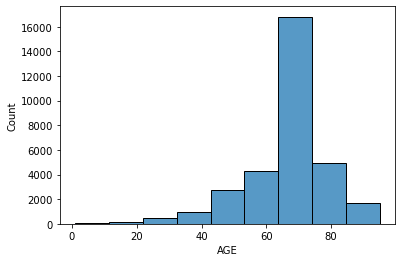

In [7]:
sns.histplot(data=merged_df, x='AGE', bins=9)

## Age Distribution on Labels {-}

<AxesSubplot:>

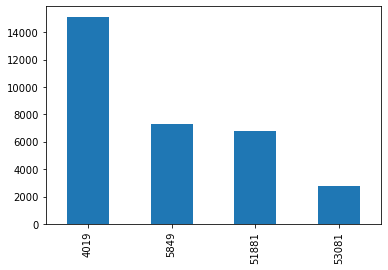

In [8]:
merged_df['ICD9_CODE'].value_counts().plot(kind='bar')

In [9]:
merged_4019 = merged_df[merged_df['ICD9_CODE'] == 4019]
merged_5849 = merged_df[merged_df['ICD9_CODE'] == 5849]
merged_51881 = merged_df[merged_df['ICD9_CODE'] == 51881]
merged_53081 = merged_df[merged_df['ICD9_CODE'] == 53081]

In [10]:
merged_4019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15125 entries, 15 to 31975
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HADM_ID         15125 non-null  float64
 1   SEQ_NUM         15125 non-null  float64
 2   ICD9_CODE       15125 non-null  int64  
 3   CATEGORY        15125 non-null  object 
 4   TEXT            15125 non-null  object 
 5   AGE             15125 non-null  int64  
 6   ROW_ID          15125 non-null  int64  
 7   SUBJECT_ID      15125 non-null  int64  
 8   ADMISSION_TYPE  15125 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


<AxesSubplot:xlabel='AGE', ylabel='Density'>

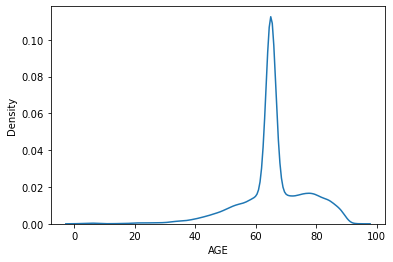

In [11]:
# label = 4019
sns.kdeplot(data=merged_4019, x='AGE')

<AxesSubplot:xlabel='AGE', ylabel='Density'>

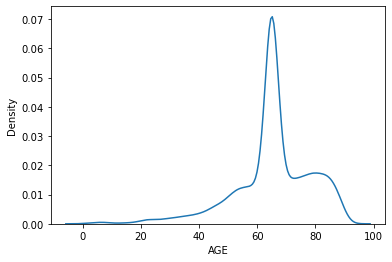

In [12]:
# label = 5849
sns.kdeplot(data=merged_5849, x='AGE')

<AxesSubplot:xlabel='AGE', ylabel='Density'>

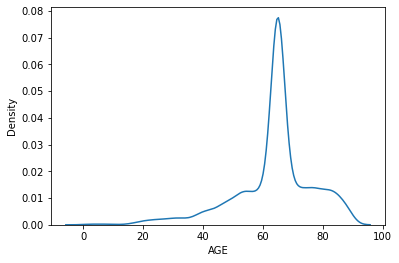

In [13]:
# label = 51881
sns.kdeplot(data=merged_51881, x='AGE')

<AxesSubplot:xlabel='AGE', ylabel='Density'>

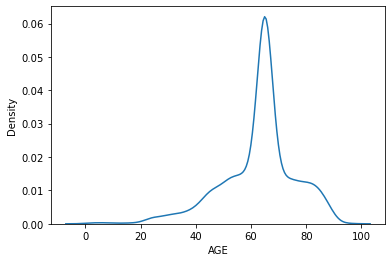

In [14]:
# label = 53081
sns.kdeplot(data=merged_53081, x='AGE')

In [15]:
print(merged_df.TEXT[31285])

82 YR. OLD MAN S/P FALL AT HOME->LG L. SDH WITH SHIFT. INTUBATED FOR AIRWAY PROTECTION. [**7-19**]->OR FOR EVACUATION OF SDH C/B NSTEMI & STROKE.
REMAINS UNRESPONSIVE SINCE SURGERY. DNR->MOVING TOWARDS CMO.

NEURO: UNRESPONSIVE. DOES NOT OPEN EYES. DOES NOT FOLLOW COMMANDS. DOES NOT HAVE ANY PURPOSEFUL MOVEMENTS. PUPILS PINPOINT.

RESP: ON VENT: 40%/TV 550/AC 14/PEEP 5. BS COURSE BUT DIMINISHED AT BASES. RR 21-26/14. O2 SAT 100%. SX FOR SM.-MOD. AMTS THICK WHITE SPUTUM.

CARDIAC: HR 66-91 SR WITH RARE PVC/COUPLET. BP 90-123/35-66. CVP 3-10.

GI:  NPO. OGT IN PLACE FOR MEDS. ABD SL. DISTENDED. BS HYPOACTIVE. SM. AMT. GOLDEN LIQUID STOOL VIA MUSHROOM CATHETER.

GU: FOLEY->CD PATENT & DRAINING YELLOW URINE WITH SEDIMENT. U/O 25-60
CC/HR.

ID: T(MAX)99.8(PO). CONT ON IV VANCO, PIPERACILLIN, & FLAGGYL. SPUTUM C&S (-), URINE C&S (-), STOOL C DIFF (-) X1->2 MORE PENDING. MRSA SCREEN (-). BC PENDING.

SKIN: HEAD INCISION OTA, C&D, SL. PINK. DUODERM INTACT TO R. GLUT.

ENDO: BS 183->177. INSULI

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31977 entries, 0 to 31976
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HADM_ID         31977 non-null  float64
 1   SEQ_NUM         31977 non-null  float64
 2   ICD9_CODE       31977 non-null  int64  
 3   CATEGORY        31977 non-null  object 
 4   TEXT            31977 non-null  object 
 5   AGE             31977 non-null  int64  
 6   ROW_ID          31977 non-null  int64  
 7   SUBJECT_ID      31977 non-null  int64  
 8   ADMISSION_TYPE  31977 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 2.2+ MB


## Additional Data Preprocessing {-}

In [17]:
def filter_admission_text(notes_df) -> pd.DataFrame:
    """
    Filter text information by section and only keep sections that are known on admission time.
    """
    admission_sections = {
        "CHIEF_COMPLAINT": "chief complaint:",
        "PRESENT_ILLNESS": "present illness:",
        "MEDICAL_HISTORY": "medical history:",
        "MEDICATION_ADM": "medications on admission:",
        "ALLERGIES": "allergies:",
        "PHYSICAL_EXAM": "physical exam:",
        "FAMILY_HISTORY": "family history:",
        "SOCIAL_HISTORY": "social history:"
    }

    # replace linebreak indicators
    notes_df['TEXT'] = notes_df['TEXT'].str.replace(r"\n", r"\\n")

    # extract each section by regex
    for key in admission_sections.keys():
        section = admission_sections[key]
        notes_df[key] = notes_df.TEXT.str.extract(r'(?i){}(.+?)\\n\\n[^(\\|\d|\.)]+?:'
                                                  .format(section))

        notes_df[key] = notes_df[key].str.replace(r'\\n', r' ')
        notes_df[key] = notes_df[key].str.strip()
        notes_df[key] = notes_df[key].fillna("")
        notes_df[notes_df[key].str.startswith("[]")][key] = ""

    # filter notes with missing main information
#     notes_df = notes_df[(notes_df.CHIEF_COMPLAINT != "") | (notes_df.PRESENT_ILLNESS != "") |
#                         (notes_df.MEDICAL_HISTORY != "")]

    # add section headers and combine into TEXT_ADMISSION
    notes_df = notes_df.assign(TEXT="CHIEF COMPLAINT: " + notes_df.CHIEF_COMPLAINT.astype(str)
                                    + '\n\n' +
                                    "PRESENT ILLNESS: " + notes_df.PRESENT_ILLNESS.astype(str)
                                    + '\n\n' +
                                    "MEDICAL HISTORY: " + notes_df.MEDICAL_HISTORY.astype(str)
                                    + '\n\n' +
                                    "MEDICATION ON ADMISSION: " + notes_df.MEDICATION_ADM.astype(str)
                                    + '\n\n' +
                                    "ALLERGIES: " + notes_df.ALLERGIES.astype(str)
                                    + '\n\n' +
                                    "PHYSICAL EXAM: " + notes_df.PHYSICAL_EXAM.astype(str)
                                    + '\n\n' +
                                    "FAMILY HISTORY: " + notes_df.FAMILY_HISTORY.astype(str)
                                    + '\n\n' +
                                    "SOCIAL HISTORY: " + notes_df.SOCIAL_HISTORY.astype(str))

    return notes_df

In [19]:
merged_df_filter_admission = filter_admission_text(merged_df)

<ipython-input-17-90940ccf6c72>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  notes_df['TEXT'] = notes_df['TEXT'].str.replace(r"\n", r"\\n")
<ipython-input-17-90940ccf6c72>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  notes_df[key] = notes_df[key].str.replace(r'\\n', r' ')
<ipython-input-17-90940ccf6c72>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes_df[notes_df[key].str.startswith("[]")][key] = ""


In [20]:
print(merged_df_filter_admission.TEXT[10])

CHIEF COMPLAINT: S/P Fall, Dsypnea

PRESENT ILLNESS: Patient is a 70 y.o. female with COPD, on home O2 (? L) who was admitted s/p fall by accidentally tripping over a soda bottle. She reports that her only injury was hitting her head near her nose. She denies loss of conciousness. Ambulance was called and EMS found her hypoxic with sats of 79% on RA. She continued to be hypoxic in the ED and was noted to have a cough productive of yellow sputum. She denies F/C, N/V/D, sick contacts, recent travel, LE swelling, CP. CT head showed no intracranial hemorrhage. CXR showed no acute process. ABG was obtained and significant for respiratory acidosis at 7.23/96/84 with chem 7 HC03 of 33. She was started on BiPAP in the ED and admitted to the ICU for further management of her hypercarbic respiratory failure. Of note, patient was given a brief steroid taper on Wednesday, [**4-13**] for what seems to be a COPD exacerbation. She completed this taper on Friday, [**4-15**].  <br>In the ICU, she was o

In [21]:
merged_df_filter_admission.head()

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID,ADMISSION_TYPE,CHIEF_COMPLAINT,PRESENT_ILLNESS,MEDICAL_HISTORY,MEDICATION_ADM,ALLERGIES,PHYSICAL_EXAM,FAMILY_HISTORY,SOCIAL_HISTORY
0,153714.0,1.0,5849,Discharge summary,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This is ...,51,29492,24136,EMERGENCY,,This is a 51-year-old gentleman who was diagno...,Notable for a viral cardiomyopathy diagnosed o...,,He has no known drug allergies.,,"Unavailable, as he is adopted.",He quit smoking in [**2139**] and has an appro...
1,165367.0,1.0,51881,Nursing/other,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,36317,29799,EMERGENCY,,,,,,,,
2,129565.0,1.0,51881,Discharge summary,CHIEF COMPLAINT: shortness of breath\n\nPRESEN...,79,47150,62854,EMERGENCY,shortness of breath,Mr. [**Known lastname **] is a 79 year old man...,*bladder cancer s/p neobladder *prior UTI *rec...,"--meprazole 20 mg Capsule, Delayed Release(E.C...",Bactrim DS / Levaquin / Sulfa (Sulfonamide Ant...,Discharge physical exam: Vitals: T 97.5 BP 134...,Denies family hx of heart disease. Mother died...,Pt is married and lives w/ wife. Rare EtOH; no...
3,141170.0,1.0,51881,Nursing,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,36132,29631,EMERGENCY,,,,,,,,
4,184643.0,1.0,5849,Discharge summary,CHIEF COMPLAINT: # PEA arrest\n\nPRESENT ILLNE...,59,17278,14106,EMERGENCY,# PEA arrest,"59 yo man with pmhx CRI (3.7-4.7= baseline), H...",CKD (baseline 3.7-4.7) - Atrophic right kidney...,Medications at home: simvastatin 80 mg qhs lis...,Shellfish Derived,Physical Exam on admission to MICU: VS: Temp: ...,"no kidney disease, father with hx of MI age 79",occasional cigarette since young and occasiona...


In [22]:
merged_df_filter_admission = merged_df_filter_admission.iloc[:, :8]
merged_df_filter_admission

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID
0,153714.0,1.0,5849,Discharge summary,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This is ...,51,29492,24136
1,165367.0,1.0,51881,Nursing/other,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,36317,29799
2,129565.0,1.0,51881,Discharge summary,CHIEF COMPLAINT: shortness of breath\n\nPRESEN...,79,47150,62854
3,141170.0,1.0,51881,Nursing,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,36132,29631
4,184643.0,1.0,5849,Discharge summary,CHIEF COMPLAINT: # PEA arrest\n\nPRESENT ILLNE...,59,17278,14106
...,...,...,...,...,...,...,...,...
31972,154989.0,32.0,53081,Nursing/other,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,30465,24955
31973,133827.0,32.0,53081,Radiology,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,73,48045,65659
31974,179548.0,32.0,4019,Discharge summary,CHIEF COMPLAINT: Weakness/Fluid Overload\n\nPR...,79,48580,67348
31975,129551.0,36.0,4019,Radiology,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,51,51769,77282


In [23]:
merged_df_filter_admission = merged_df_filter_admission.reset_index(drop=True)
merged_df_filter_admission

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID
0,153714.0,1.0,5849,Discharge summary,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This is ...,51,29492,24136
1,165367.0,1.0,51881,Nursing/other,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,36317,29799
2,129565.0,1.0,51881,Discharge summary,CHIEF COMPLAINT: shortness of breath\n\nPRESEN...,79,47150,62854
3,141170.0,1.0,51881,Nursing,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,36132,29631
4,184643.0,1.0,5849,Discharge summary,CHIEF COMPLAINT: # PEA arrest\n\nPRESENT ILLNE...,59,17278,14106
...,...,...,...,...,...,...,...,...
31972,154989.0,32.0,53081,Nursing/other,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,65,30465,24955
31973,133827.0,32.0,53081,Radiology,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,73,48045,65659
31974,179548.0,32.0,4019,Discharge summary,CHIEF COMPLAINT: Weakness/Fluid Overload\n\nPR...,79,48580,67348
31975,129551.0,36.0,4019,Radiology,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: \n\nMEDI...,51,51769,77282


In [24]:
merged_df_filter_admission['ICD9_CODE'].isnull().sum()

0

In [25]:
merged_df_filter_admission.to_csv('topic_modeling_admission_df_with_age_filtered.csv', index=False)

## Data Exploration {-}

<AxesSubplot:>

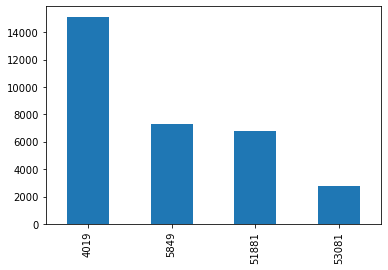

In [26]:
merged_df_filter_admission['ICD9_CODE'].value_counts().plot(kind='bar')

In [27]:
X, y = merged_df_filter_admission.TEXT, merged_df_filter_admission.ICD9_CODE

## Text Cleaning {-}

In [28]:
my_stop_words = ['discharge', 'diagnosis', 'medications', 'medication', 'disposition', 'condition', 'instructions', 
                 'status', 'secondary', 'changes', 'instruction', 'change', 'home', 'name', 'hospital', 'daily',
                'hour', 'follow', 'care', 'time', 'day', 'week', 'with', 'disp', 'discharged', 'admitted', 
                 'namepattern', 'none']

In [29]:
documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    # Remove new line characters
    document = document.replace("\n", ' ')
    # Punctuation
    document = re.sub(r'[^\w\s]', ' ', document)
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    #Removing Numbers
    document = ''.join(i for i in document if not i.isdigit())
    #Removing Stopwords
    document = ' '.join([i for i in document.split() if not i in all_stopwords])
    #Removing certain sized words
    document = ' '.join([i for i in document.split() if len(i)>3])
    # Contractions
    document = contractions.fix(document)
    # Converting to Lowercase
    document = document.lower()
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    #Removing my_stop_words
    document = ' '.join([i for i in document.split() if not i in my_stop_words])
    
    #return document
    documents.append(document)

In [30]:
X = documents
X

['chief complaint present illness this year gentleman diagnosed month cardiomyopathy following viral illness inferior apical akinesis ejection fraction estimated percent sent stable cardiac renal function heart failure regiment prior admission began feel unwell nasal congestion fatigue five prior admission began experience nausea vomiting diarrhea evidence blood difficult keeping fluid able prior admission noted feeling cloudy thought confused brought emergency room location university college admission previously started regimen newly diagnosed viral cardiomyopathy including coreg coumadin lasix lisinopril changed valsartan when presented found reported creatinine potassium thought acute renal failure given liter normal saline bicarbonate insulin glucose kayexalate hyperkalemia transferred reported chest pain palpitation abdominal pain melena numbness tingling foot shortness breath lower extremity edema medical history notable viral cardiomyopathy diagnosed ejection fraction percent h

In [31]:
type(X)

list

## TFIDF Vectorizer {-}

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [34]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df

,____,_____,______,_______,________,_________,__________,___________,______________,_______________,...,zygoesophageal,zygoma,zygomatic,zyloprim,zymar,zyprexa,zyrtec,zytec,zytiga,zyvox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting Training and Testing Sets {-}

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Training Models {-}

In [37]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression Multi-class
from sklearn.linear_model import LogisticRegression #multi_class = 'multinomial'

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Linear Support Vector Classifier
from sklearn.svm import LinearSVC #multi_class=”crammer_singer”

In [38]:
classifier_1 = DecisionTreeClassifier()
classifier_1.fit(X_train, y_train)

DecisionTreeClassifier()

In [39]:
classifier_2 = MultinomialNB()
classifier_2.fit(X_train, y_train)

MultinomialNB()

In [40]:
classifier_3 = LogisticRegression(multi_class = 'multinomial')
classifier_3.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [41]:
classifier_4 = RandomForestClassifier()
classifier_4.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
classifier_5 = LinearSVC(multi_class = 'crammer_singer')
classifier_5.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(multi_class='crammer_singer')

## Testing Models {-}

In [43]:
y_pred_dtc = classifier_1.predict(X_test)

In [44]:
y_pred_mnb = classifier_2.predict(X_test)

In [45]:
y_pred_lr = classifier_3.predict(X_test)

In [46]:
y_pred_rfc = classifier_4.predict(X_test)

In [47]:
y_pred_lsvc = classifier_5.predict(X_test)

## Evaluating Each Model {-}

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [49]:
print('DECISION TREE RESULTS\n')
print(confusion_matrix(y_test,y_pred_dtc))
print(classification_report(y_test,y_pred_dtc))
print(accuracy_score(y_test, y_pred_dtc))

DECISION TREE RESULTS

[[4041  222  166   80]
 [1822  230   94   59]
 [1696  102  237   23]
 [ 679   39   36   68]]
              precision    recall  f1-score   support

        4019       0.49      0.90      0.63      4509
        5849       0.39      0.10      0.16      2205
       51881       0.44      0.12      0.18      2058
       53081       0.30      0.08      0.13       822

    accuracy                           0.48      9594
   macro avg       0.40      0.30      0.28      9594
weighted avg       0.44      0.48      0.39      9594

0.47696476964769646


In [50]:
print('MULTINOMIAL NAIVE BAYES RESULTS\n')
print(confusion_matrix(y_test,y_pred_mnb))
print(classification_report(y_test,y_pred_mnb))
print(accuracy_score(y_test, y_pred_mnb))

MULTINOMIAL NAIVE BAYES RESULTS

[[4458   37   14    0]
 [2037  153   15    0]
 [1923   54   81    0]
 [ 791   25    6    0]]
              precision    recall  f1-score   support

        4019       0.48      0.99      0.65      4509
        5849       0.57      0.07      0.12      2205
       51881       0.70      0.04      0.07      2058
       53081       0.00      0.00      0.00       822

    accuracy                           0.49      9594
   macro avg       0.44      0.27      0.21      9594
weighted avg       0.51      0.49      0.35      9594

0.4890556597873671


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print('LOGISITIC REGRESSION RESULTS\n')
print(confusion_matrix(y_test,y_pred_lr))
print(classification_report(y_test,y_pred_lr))
print(accuracy_score(y_test, y_pred_lr))

LOGISITIC REGRESSION RESULTS

[[4309  122   75    3]
 [1822  319   60    4]
 [1710   72  275    1]
 [ 730   53   27   12]]
              precision    recall  f1-score   support

        4019       0.50      0.96      0.66      4509
        5849       0.56      0.14      0.23      2205
       51881       0.63      0.13      0.22      2058
       53081       0.60      0.01      0.03       822

    accuracy                           0.51      9594
   macro avg       0.57      0.31      0.28      9594
weighted avg       0.55      0.51      0.41      9594

0.5122993537627684


In [52]:
print('RANDOM FOREST RESULTS\n')
print(confusion_matrix(y_test,y_pred_rfc))
print(classification_report(y_test,y_pred_rfc))
print(accuracy_score(y_test, y_pred_rfc))

RANDOM FOREST RESULTS

[[4404   55   47    3]
 [1970  198   37    0]
 [1798   59  200    1]
 [ 784   17   21    0]]
              precision    recall  f1-score   support

        4019       0.49      0.98      0.65      4509
        5849       0.60      0.09      0.16      2205
       51881       0.66      0.10      0.17      2058
       53081       0.00      0.00      0.00       822

    accuracy                           0.50      9594
   macro avg       0.44      0.29      0.24      9594
weighted avg       0.51      0.50      0.38      9594

0.5005211590577444


In [53]:
print('LINEAR SUPPORT VECTOR CLASSIFIER RESULTS\n')
print(confusion_matrix(y_test,y_pred_lsvc))
print(classification_report(y_test,y_pred_lsvc))
print(accuracy_score(y_test, y_pred_lsvc))

LINEAR SUPPORT VECTOR CLASSIFIER RESULTS

[[4215  152  101   41]
 [1793  300   93   19]
 [1689   73  282   14]
 [ 702   39   33   48]]
              precision    recall  f1-score   support

        4019       0.50      0.93      0.65      4509
        5849       0.53      0.14      0.22      2205
       51881       0.55      0.14      0.22      2058
       53081       0.39      0.06      0.10       822

    accuracy                           0.51      9594
   macro avg       0.50      0.32      0.30      9594
weighted avg       0.51      0.51      0.41      9594

0.5050031269543465


## Feature Importance Ranking With Random Forest {-}

In [54]:
feature_importances=pd.DataFrame({'feature':vectorizer.get_feature_names(),'feature_importance':classifier_4.feature_importances_})
important_features = feature_importances.sort_values('feature_importance',ascending=False).head(40)
important_features

,feature,feature_importance
13860,intubated,0.005978
10960,gerd,0.004933
12541,hypertension,0.004535
5408,complaint,0.004528
22560,respiratory,0.004403
19721,physical,0.004101
9356,exam,0.004097
4577,chief,0.004026
23596,sedated,0.003958
12040,history,0.003944


In [55]:
important_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 13860 to 6872
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   feature             40 non-null     object 
 1   feature_importance  40 non-null     float64
dtypes: float64(1), object(1)
memory usage: 960.0+ bytes


In [56]:
important_features_list = list(important_features['feature'])
important_features_list

['intubated',
 'gerd',
 'hypertension',
 'complaint',
 'respiratory',
 'physical',
 'exam',
 'chief',
 'sedated',
 'history',
 'illness',
 'admission',
 'social',
 'medical',
 'allergy',
 'renal',
 'present',
 'family',
 'baseline',
 'heent',
 'creatinine',
 'failure',
 'pain',
 'year',
 'left',
 'known',
 'life',
 'patient',
 'drug',
 'given',
 'intubation',
 'chronic',
 'right',
 'soft',
 'cough',
 'artery',
 'chill',
 'chest',
 'lasix',
 'denies']

## Creating Important Features DataFrame Using TF-IDF {-}

In [57]:
words = tfidf_df[important_features_list]
label = merged_df_filter_admission['ICD9_CODE']
age = merged_df_filter_admission['AGE']

tfidf_feature_importances_with_age_df = pd.concat([age, label, words], axis=1)
tfidf_feature_importances_with_age_df

,AGE,ICD9_CODE,intubated,gerd,hypertension,complaint,respiratory,physical,exam,chief,...,intubation,chronic,right,soft,cough,artery,chill,chest,lasix,denies
0,51,5849,0.000000,0.000000,0.039164,0.012983,0.0,0.012983,0.012983,0.012983,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038946,0.051127,0.000000
1,65,51881,0.000000,0.000000,0.000000,0.223607,0.0,0.223607,0.223607,0.223607,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,79,51881,0.000000,0.047611,0.034641,0.011484,0.0,0.022968,0.022968,0.011484,...,0.0,0.040374,0.070269,0.033270,0.000000,0.000000,0.000000,0.068897,0.000000,0.035132
3,65,51881,0.000000,0.000000,0.000000,0.223607,0.0,0.223607,0.223607,0.223607,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,59,5849,0.046937,0.000000,0.034157,0.011323,0.0,0.022647,0.022647,0.011323,...,0.0,0.000000,0.034643,0.032804,0.042153,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31972,65,53081,0.000000,0.000000,0.000000,0.223607,0.0,0.223607,0.223607,0.223607,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31973,73,53081,0.000000,0.000000,0.000000,0.223607,0.0,0.223607,0.223607,0.223607,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31974,79,4019,0.000000,0.000000,0.020608,0.013664,0.0,0.013664,0.006832,0.006832,...,0.0,0.000000,0.000000,0.039584,0.025432,0.025667,0.025766,0.040987,0.000000,0.062700
31975,51,4019,0.000000,0.000000,0.000000,0.223607,0.0,0.223607,0.223607,0.223607,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
tfidf_feature_importances_with_age_df['ICD9_CODE'].isnull().sum()

0

In [59]:
tfidf_feature_importances_with_age_df['AGE'].isnull().sum()

0

In [60]:
tfidf_feature_importances_with_age_df.to_csv('tfidf_admission_mimic_no_zeros.csv', index=False)

## Building TFIDF with Top 6 Topic Model Words {-}

In [61]:
# topic_model_list = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/3. Topic Modeling/topic_words_list_series_top_6_words_age_filtered.csv')
# topic_model_list

In [62]:
# topic_words_list = topic_model_list['0'].tolist()
# topic_words_list

In [63]:
# words = tfidf_df[topic_words_list]
# label = merged_df_filter_discharge['ICD9_CODE']
# age = merged_df_filter_discharge['AGE']

# tfidf_feature_importances_with_age_top_6_words_df = pd.concat([age, label, words], axis=1)
# tfidf_feature_importances_with_age_top_6_words_df

In [64]:
# tfidf_feature_importances_with_age_top_6_words_df['ICD9_CODE'].isnull().sum()

In [65]:
# tfidf_feature_importances_with_age_top_6_words_df['AGE'].isnull().sum()

In [66]:
# tfidf_feature_importances_with_age_top_6_words_df.to_csv('tfidf_feature_importances_with_age_filtered_top_6_words_df.csv', index=False)

## Sanity Check {-}

In [67]:
# tfidf_test = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/2. Cleaning Balancing TFIDF/tfidf_feature_importances_imbalanced_with_age_filtered.csv')
# tfidf_test

In [68]:
# tfidf_feature_importances_with_age_top_6_words_test = pd.read_csv('tfidf_feature_importances_with_age_filtered_top_6_words_df.csv')
# tfidf_feature_importances_with_age_top_6_words_test

In [ ]:
# topic_modeling_df_test = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/3. Topic Modeling/topic_modeling_11_topics_with_age_filtered.csv')
# topic_modeling_df_test